# PSO Path Planning Experiment
This notebook demonstrates path planning in a warehouse grid using Particle Swarm Optimization (PSO).

The generalized implementation allows testing different environment configurations, obstacle patterns, and PSO parameters.

In [61]:
# Add src directory to path and import libraries
import sys
import os

# Ensure we're using the correct path
current_dir = os.path.dirname(os.getcwd()) if os.path.basename(os.getcwd()) == 'notebooks' else os.getcwd()
src_path = os.path.join(current_dir, 'src') if os.path.basename(current_dir) == 'ai-pso-final' else os.path.join(os.path.dirname(current_dir), 'src')
sys.path.append(src_path)
print(f"Added path: {src_path}")

# Import core libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from datetime import datetime

# Ensure matplotlib is properly configured for Jupyter
%matplotlib inline

# Reload modules to ensure we get the latest version
import importlib

Added path: c:\Users\Asus\OneDrive\Desktop\clg\ai-pso-final\src


In [62]:
# Debugging: Let's check the source code in warehouse_env.py
import inspect
import os

# Path to the file
env_file = os.path.join(src_path, "warehouse_env.py")
print(f"File path: {env_file}")
print(f"File exists: {os.path.exists(env_file)}")

# Print file contents
if os.path.exists(env_file):
    with open(env_file, 'r') as f:
        print("\n--- warehouse_env.py contents ---")
        print(f.read())
else:
    print("File not found!")

File path: c:\Users\Asus\OneDrive\Desktop\clg\ai-pso-final\src\warehouse_env.py
File exists: True

--- warehouse_env.py contents ---
import numpy as np

class WarehouseGrid:
    def __init__(self, rows, cols, start, goal, obstacles):
        self.rows = rows
        self.cols = cols
        self.start = start
        self.goal = goal
        self.obstacles = obstacles  # Properly expose obstacles as an attribute
        self.grid = np.zeros((rows, cols))
        for (i, j) in obstacles:
            self.grid[i, j] = 1  # Mark obstacles

    def display(self):
        for row in self.grid:
            print(row)
            
    def is_valid(self, pos):
        i, j = pos
        return (0 <= i < self.rows and 
                0 <= j < self.cols and 
                pos not in self.obstacles)



In [63]:
# Manual implementation of WarehouseGrid
import numpy as np

class WarehouseGridFixed:
    def __init__(self, rows, cols, start, goal, obstacles):
        self.rows = rows
        self.cols = cols
        self.start = start
        self.goal = goal
        self.obstacles = obstacles  # Explicitly set obstacles attribute
        self.grid = np.zeros((rows, cols))
        for (i, j) in obstacles:
            self.grid[i, j] = 1  # Mark obstacles

    def display(self):
        for row in self.grid:
            print(row)

    def is_valid(self, pos):
        i, j = pos
        return (0 <= i < self.rows and 
                0 <= j < self.cols and 
                pos not in self.obstacles)

# Now import our modules
from fitness import fitness_function
from pso import PSO, Particle  # Import Particle class directly
from visualize import plot_grid

## Environment Generation Functions
Helper functions to create different environment configurations.

In [64]:
# Environment generation functions
def create_maze_environment(rows=10, cols=10, obstacle_density=0.3, seed=None):
    """Create a random maze-like environment"""
    if seed is not None:
        np.random.seed(seed)
    
    # Start and goal at opposite corners
    start = (0, 0)
    goal = (rows-1, cols-1)
    
    # Random obstacles (excluding start and goal)
    obstacles = []
    for i in range(rows):
        for j in range(cols):
            if (i, j) != start and (i, j) != goal:
                if np.random.random() < obstacle_density:
                    obstacles.append((i, j))
    
    # Ensure there's a path from start to goal (simple check - remove blocking obstacles)
    # This is a simple approach and doesn't guarantee pathfinding success
    middle_path = []
    for i in range(rows):
        middle_path.append((i, cols//2))
    for j in range(cols):
        middle_path.append((rows//2, j))
    
    # Remove obstacles that block the middle path
    obstacles = [obs for obs in obstacles if obs not in middle_path]
    
    return WarehouseGridFixed(rows, cols, start, goal, obstacles)

def create_corridor_environment(rows=10, cols=10, corridor_width=1):
    """Create an environment with corridors"""
    start = (0, 0)
    goal = (rows-1, cols-1)
    
    # Create walls with passages
    obstacles = []
    for wall_pos in range(2, rows-1, 3):  # Walls at positions 2, 5, 8...
        passage = np.random.randint(0, cols-corridor_width)
        for i in range(cols):
            if i < passage or i >= passage + corridor_width:
                obstacles.append((wall_pos, i))
    
    return WarehouseGridFixed(rows, cols, start, goal, obstacles)

def create_warehouse_environment(rows=15, cols=15, shelf_length=5, num_shelves=3):
    """Create a warehouse-like environment with shelves"""
    start = (0, 0)
    goal = (rows-1, cols-1)
    
    obstacles = []
    # Create horizontal shelves with passages
    for shelf_idx in range(num_shelves):
        shelf_row = (shelf_idx + 1) * (rows // (num_shelves + 1))
        passage = np.random.randint(0, cols - 2)  # Leave space for passage
        
        for i in range(cols):
            if i < passage or i > passage + 1:  # 2-unit passage
                for j in range(shelf_length):
                    if shelf_row + j < rows:
                        obstacles.append((shelf_row + j, i))
    
    return WarehouseGridFixed(rows, cols, start, goal, obstacles)

## Environment Setup
Create different environment configurations to test the PSO algorithm's adaptability.

Original environment created with 19 obstacles
Maze environment created with 21 obstacles
Corridor environment created with 24 obstacles
Warehouse environment created with 195 obstacles


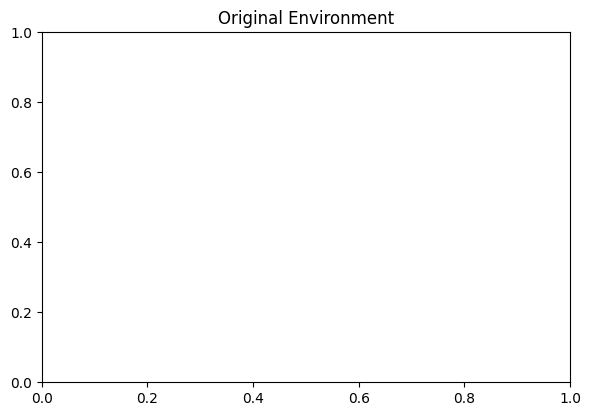

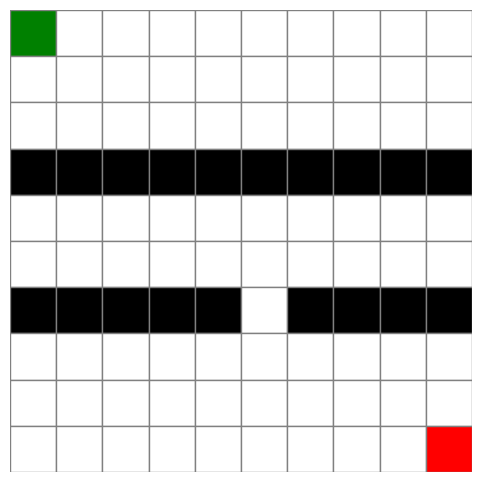

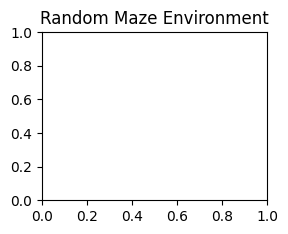

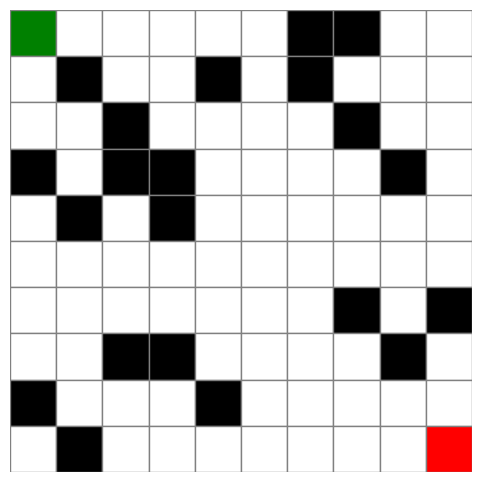

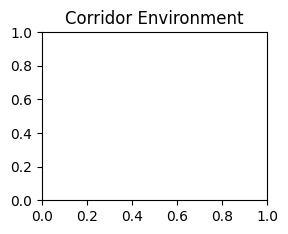

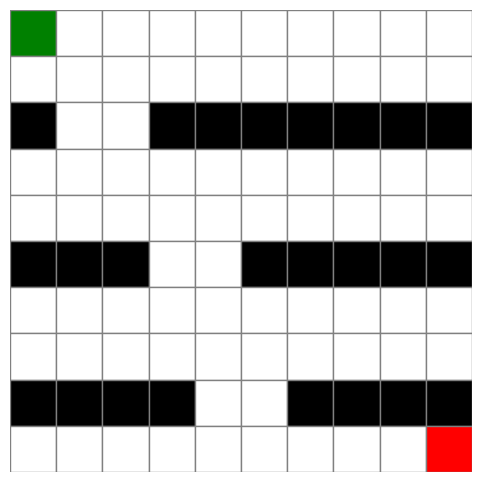

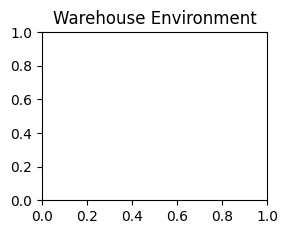

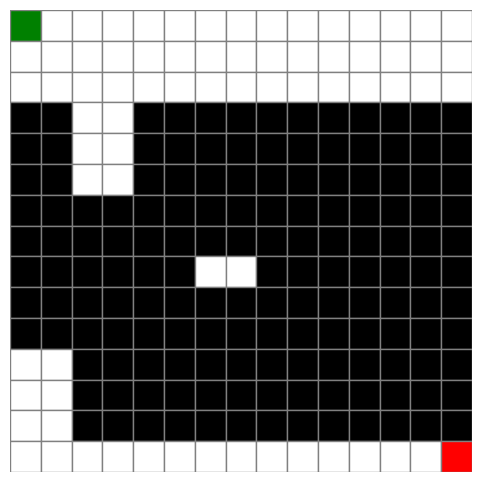

In [65]:
# Original environment setup (walls with passage)
rows, cols = 10, 10
start = (0, 0)
goal = (9, 9)
obstacles = [(3, i) for i in range(10)] + [(6, i) for i in range(10) if i != 5]

# Create environment using our fixed class
env_original = WarehouseGridFixed(rows, cols, start, goal, obstacles)
print(f"Original environment created with {len(obstacles)} obstacles")

# Create other environment types
env_maze = create_maze_environment(rows=10, cols=10, obstacle_density=0.25, seed=42)
print(f"Maze environment created with {len(env_maze.obstacles)} obstacles")

env_corridor = create_corridor_environment(rows=10, cols=10, corridor_width=2)
print(f"Corridor environment created with {len(env_corridor.obstacles)} obstacles")

env_warehouse = create_warehouse_environment(rows=15, cols=15)
print(f"Warehouse environment created with {len(env_warehouse.obstacles)} obstacles")

# Visualize all environments
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.title("Original Environment")
plot_grid(env_original)

plt.subplot(2, 2, 2)
plt.title("Random Maze Environment")
plot_grid(env_maze)

plt.subplot(2, 2, 3)
plt.title("Corridor Environment")
plot_grid(env_corridor)

plt.subplot(2, 2, 4)
plt.title("Warehouse Environment")
plot_grid(env_warehouse)

## PSO Parameters
Configure the PSO algorithm parameters for path planning

In [66]:
# PSO configuration class
class PsoConfig:
    def __init__(self, swarm_size=30, iterations=100, w1=0.4, w2=0.3, w3=0.2, w4=0.1):
        self.swarm_size = swarm_size  # Number of particles
        self.iterations = iterations  # Maximum iterations
        # Fitness weights
        self.w1 = w1  # Distance weight
        self.w2 = w2  # Time weight
        self.w3 = w3  # Energy weight
        self.w4 = w4  # Collision weight
    
    def __str__(self):
        return f"PSO(swarm={self.swarm_size}, iter={self.iterations}, weights=[{self.w1},{self.w2},{self.w3},{self.w4}])"

## PSO Execution Function
Generalized function to run PSO with different configurations and environments

In [67]:
# Run PSO and collect metrics
def run_pso_experiment(env, config=None, verbose=True):
    """Run PSO on the given environment with specified config"""
    if config is None:
        config = PsoConfig()  # Use default config
    
    start_time = time.time()
    
    # Create PSO instance with the given config
    pso = PSO(env, swarm_size=config.swarm_size, iterations=config.iterations)
    
    # Extract weights from config
    weights = (config.w1, config.w2, config.w3, config.w4)
    
    # Generate initial swarm - use Particle class directly
    pso.swarm = [Particle(pso.generate_random_path()) for _ in range(pso.swarm_size)]
    pso.fitness_history = []  # Initialize fitness history

    # Run optimization using custom fitness function
    for _ in range(pso.iterations):
        for particle in pso.swarm:
            # Use custom fitness function with weights
            score = fitness_function(particle.position, pso.env, *weights)

            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = list(particle.position)

            if score < pso.global_best_score:
                pso.global_best_score = score
                pso.global_best = list(particle.position)
        
        # Record the best score of this iteration
        pso.fitness_history.append(pso.global_best_score)

        for particle in pso.swarm:
            particle.position = pso.mutate_path(particle.best_position)
    
    best_path = pso.global_best
    
    # Calculate elapsed time and metrics
    elapsed_time = time.time() - start_time
    path_length = len(best_path) if best_path else 0
    path_found = best_path[-1] == env.goal if path_length > 0 else False
    final_fitness = pso.global_best_score
    
    # Print results if verbose
    if verbose:
        print(f"\nResults for {config}:")
        print(f"Path found: {path_found}")
        print(f"Path length: {path_length}")
        print(f"Final fitness: {final_fitness:.4f}")
        print(f"Execution time: {elapsed_time:.4f} seconds")
    
    # Result metrics
    metrics = {
        "path_found": path_found,
        "path_length": path_length,
        "final_fitness": final_fitness,
        "execution_time": elapsed_time,
        "fitness_history": pso.fitness_history
    }
    
    return best_path, metrics


Running configuration: PSO(swarm=30, iter=100, weights=[0.4,0.3,0.2,0.1])

Results for PSO(swarm=30, iter=100, weights=[0.4,0.3,0.2,0.1]):
Path found: False
Path length: 5
Final fitness: 3.4314
Execution time: 0.0238 seconds


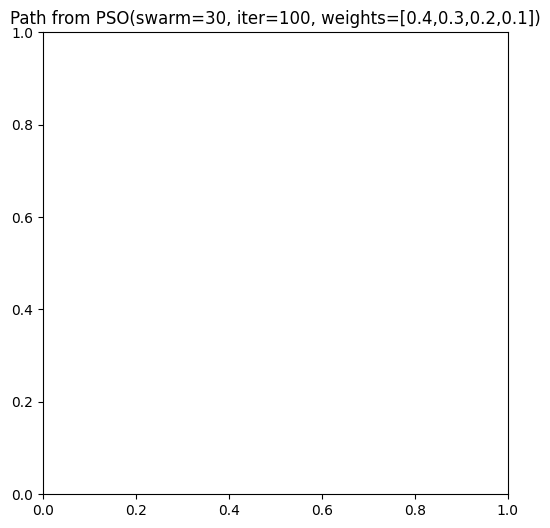

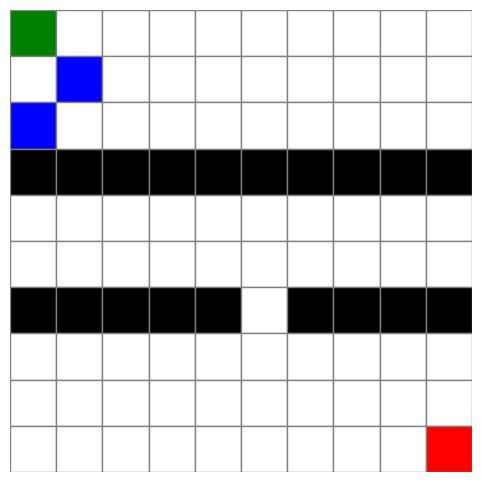


Running configuration: PSO(swarm=50, iter=150, weights=[0.5,0.2,0.2,0.1])

Results for PSO(swarm=50, iter=150, weights=[0.5,0.2,0.2,0.1]):
Path found: False
Path length: 6
Final fitness: 3.7000
Execution time: 0.0591 seconds


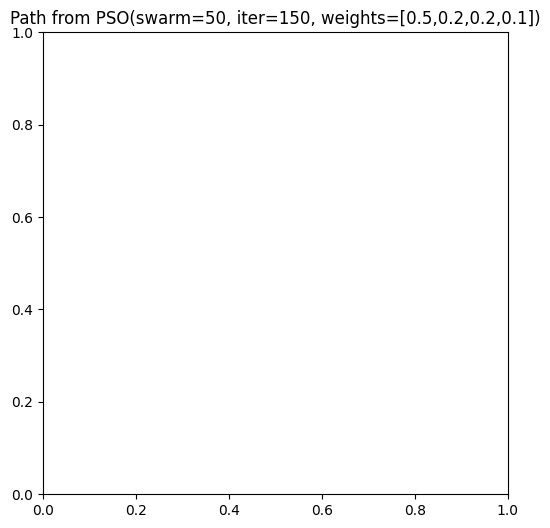

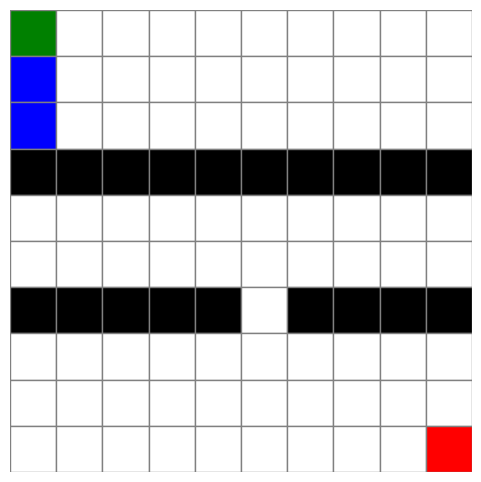


Running configuration: PSO(swarm=20, iter=80, weights=[0.3,0.4,0.2,0.1])

Results for PSO(swarm=20, iter=80, weights=[0.3,0.4,0.2,0.1]):
Path found: False
Path length: 5
Final fitness: 3.6485
Execution time: 0.0114 seconds


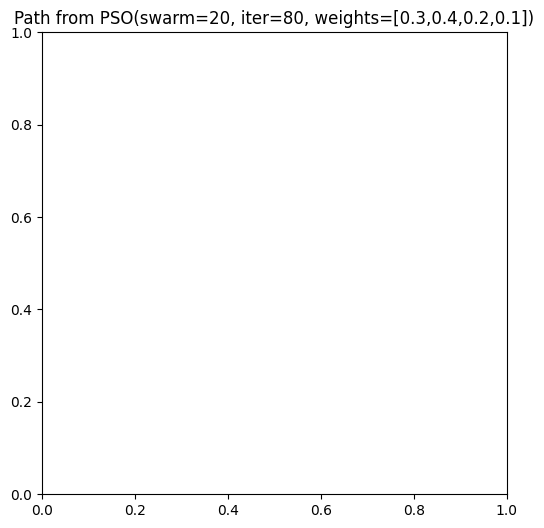

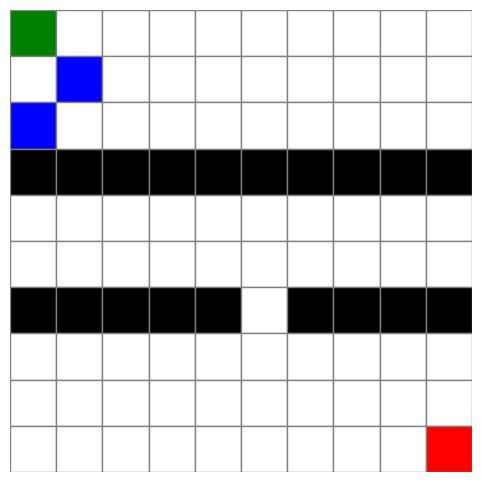

In [68]:
# Run experiments with different PSO configurations
# Define configurations to test
configs = [
    PsoConfig(swarm_size=30, iterations=100, w1=0.4, w2=0.3, w3=0.2, w4=0.1),  # Default
    PsoConfig(swarm_size=50, iterations=150, w1=0.5, w2=0.2, w3=0.2, w4=0.1),  # Larger swarm
    PsoConfig(swarm_size=20, iterations=80, w1=0.3, w2=0.4, w3=0.2, w4=0.1),   # Smaller swarm, prioritize time
]

# Select an environment to test configurations
test_env = env_original

# Run each configuration
results = []
for config in configs:
    print(f"\nRunning configuration: {config}")
    path, metrics = run_pso_experiment(test_env, config)
    results.append((config, path, metrics))
    
    # Visualize the path
    plt.figure(figsize=(6, 6))
    plt.title(f"Path from {config}")
    plot_grid(test_env, path)

## Comparing Environments
Compare PSO performance across different environment types


Running PSO on Original environment

Results for PSO(swarm=30, iter=100, weights=[0.4,0.3,0.2,0.1]):
Path found: False
Path length: 6
Final fitness: 4.2601
Execution time: 0.0246 seconds


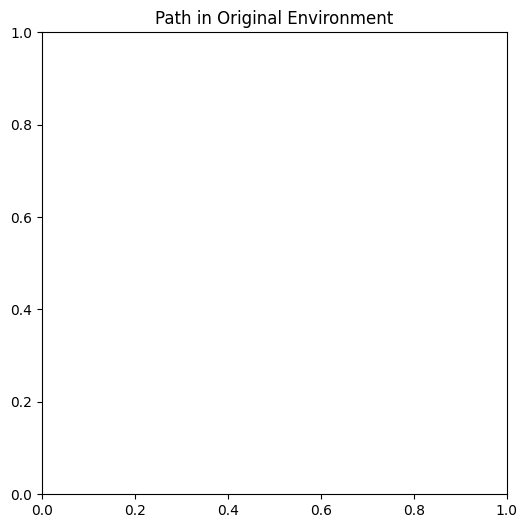

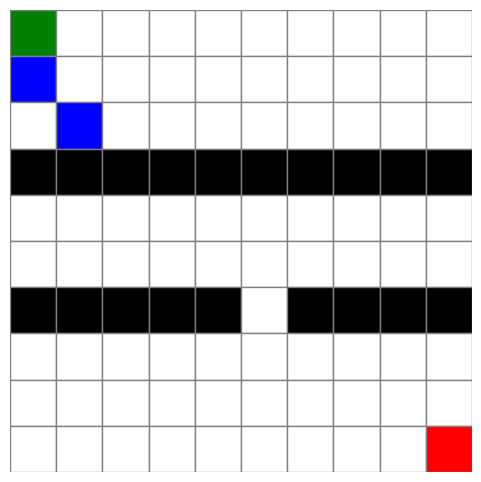


Running PSO on Maze environment

Results for PSO(swarm=30, iter=100, weights=[0.4,0.3,0.2,0.1]):
Path found: False
Path length: 5
Final fitness: 3.5649
Execution time: 0.0225 seconds


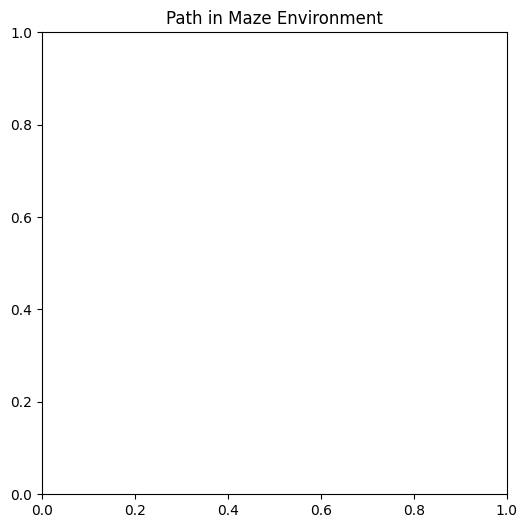

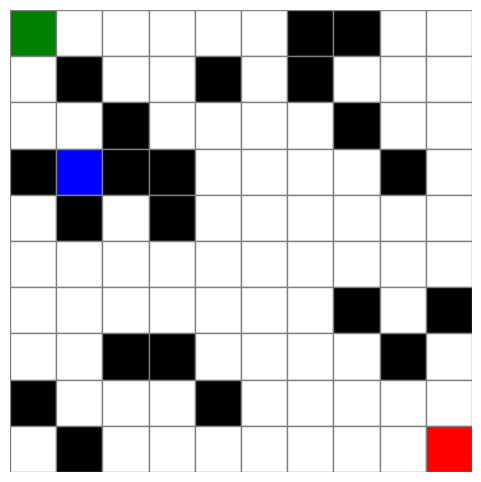


Running PSO on Corridor environment

Results for PSO(swarm=30, iter=100, weights=[0.4,0.3,0.2,0.1]):
Path found: False
Path length: 4
Final fitness: 2.2000
Execution time: 0.0217 seconds


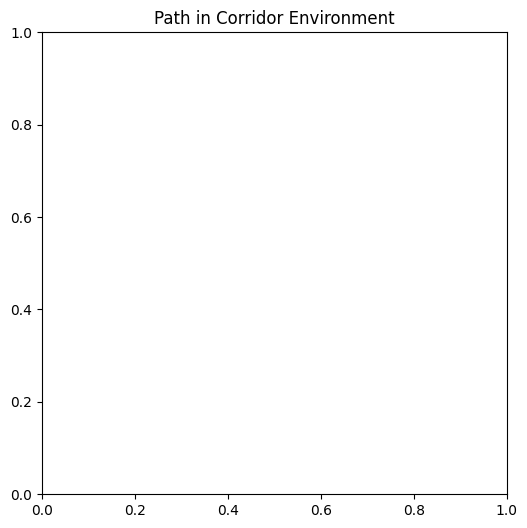

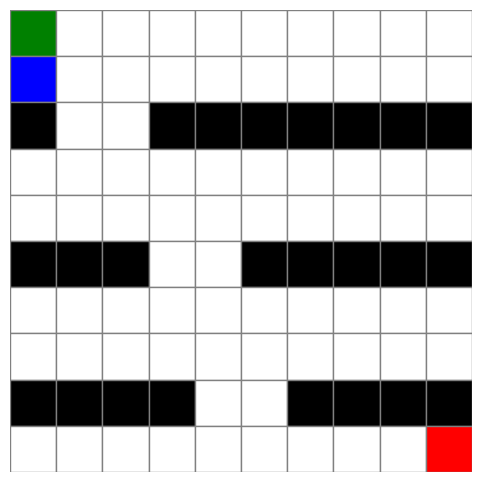


Running PSO on Warehouse environment

Results for PSO(swarm=30, iter=100, weights=[0.4,0.3,0.2,0.1]):
Path found: False
Path length: 5
Final fitness: 3.5944
Execution time: 0.0911 seconds


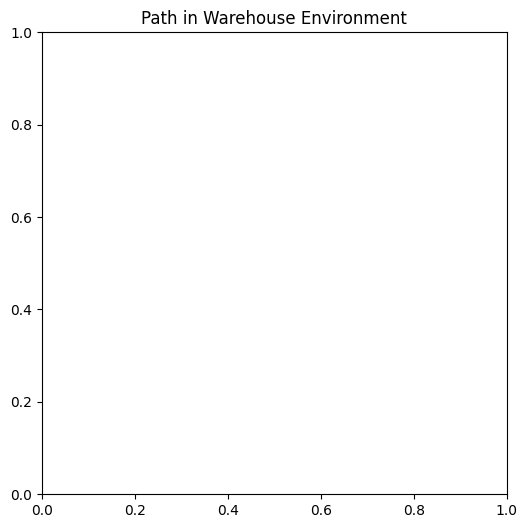

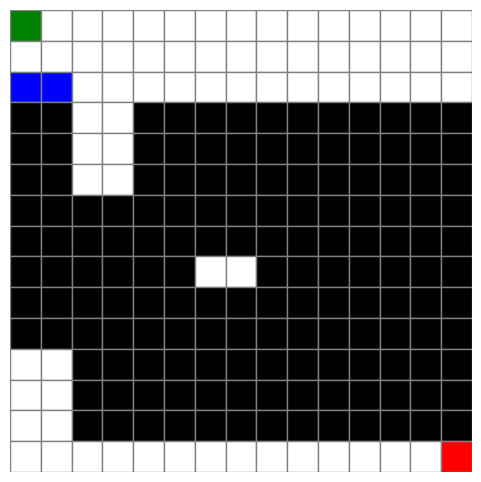

In [69]:
# Compare PSO performance on different environments using the best configuration
environments = [
    ("Original", env_original),
    ("Maze", env_maze),
    ("Corridor", env_corridor),
    ("Warehouse", env_warehouse)
]

# Use the best configuration found
best_config = configs[0]  # Replace with the index of your best configuration

# Run PSO on each environment
env_results = []
for name, env in environments:
    print(f"\nRunning PSO on {name} environment")
    path, metrics = run_pso_experiment(env, best_config)
    env_results.append((name, path, metrics))
    
    # Visualize the path
    plt.figure(figsize=(6, 6))
    plt.title(f"Path in {name} Environment")
    plot_grid(env, path)

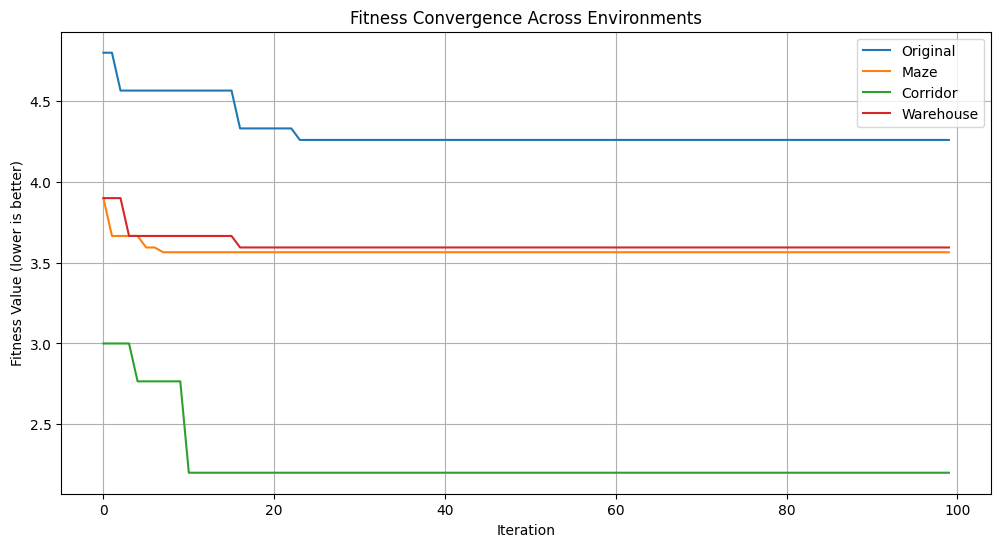

In [70]:
# Compare fitness history across environments
plt.figure(figsize=(12, 6))

for name, _, metrics in env_results:
    plt.plot(metrics['fitness_history'], label=name)

plt.title('Fitness Convergence Across Environments')
plt.xlabel('Iteration')
plt.ylabel('Fitness Value (lower is better)')
plt.grid(True)
plt.legend()
plt.show()

## Performance Summary
Summarize the performance metrics across different configurations and environments

In [71]:
# Display summary table of results
print("\n=== PSO Configuration Comparison ===")
print("{:<30} {:<15} {:<15} {:<15} {:<15}".format(
    "Configuration", "Path Found", "Path Length", "Final Fitness", "Time (s)"))

for config, _, metrics in results:
    print("{:<30} {:<15} {:<15} {:<15.4f} {:<15.4f}".format(
        str(config), 
        str(metrics['path_found']),
        metrics['path_length'],
        metrics['final_fitness'],
        metrics['execution_time']))

print("\n=== Environment Comparison ===")
print("{:<15} {:<15} {:<15} {:<15} {:<15}".format(
    "Environment", "Path Found", "Path Length", "Final Fitness", "Time (s)"))

for name, _, metrics in env_results:
    print("{:<15} {:<15} {:<15} {:<15.4f} {:<15.4f}".format(
        name, 
        str(metrics['path_found']),
        metrics['path_length'],
        metrics['final_fitness'],
        metrics['execution_time']))


=== PSO Configuration Comparison ===
Configuration                  Path Found      Path Length     Final Fitness   Time (s)       
PSO(swarm=30, iter=100, weights=[0.4,0.3,0.2,0.1]) False           5               3.4314          0.0238         
PSO(swarm=50, iter=150, weights=[0.5,0.2,0.2,0.1]) False           6               3.7000          0.0591         
PSO(swarm=20, iter=80, weights=[0.3,0.4,0.2,0.1]) False           5               3.6485          0.0114         

=== Environment Comparison ===
Environment     Path Found      Path Length     Final Fitness   Time (s)       
Original        False           6               4.2601          0.0246         
Maze            False           5               3.5649          0.0225         
Corridor        False           4               2.2000          0.0217         
Warehouse       False           5               3.5944          0.0911         


## Save Results
Save experimental results to files for future reference

In [72]:
# Save the best paths to files
results_dir = os.path.join(current_dir, 'results')
os.makedirs(results_dir, exist_ok=True)

# Save timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Save best paths from environment comparison
for name, path, metrics in env_results:
    path_file = os.path.join(results_dir, f"path_{name}_{timestamp}.txt")
    with open(path_file, 'w') as f:
        f.write(f"# Path for {name} environment\n")
        f.write(f"# Found: {metrics['path_found']}\n")
        f.write(f"# Length: {metrics['path_length']}\n")
        f.write(f"# Fitness: {metrics['final_fitness']:.4f}\n\n")
        for i, (x, y) in enumerate(path):
            f.write(f"{i}: ({x}, {y})\n")

# Save a summary file
summary_file = os.path.join(results_dir, f"summary_{timestamp}.txt")
with open(summary_file, 'w') as f:
    f.write("=== PSO Path Planning Experiment Summary ===\n\n")
    
    f.write("== Configuration Results ==\n")
    for config, _, metrics in results:
        f.write(f"\nConfiguration: {config}\n")
        f.write(f"Path Found: {metrics['path_found']}\n")
        f.write(f"Path Length: {metrics['path_length']}\n")
        f.write(f"Final Fitness: {metrics['final_fitness']:.4f}\n")
        f.write(f"Execution Time: {metrics['execution_time']:.4f} seconds\n")
    
    f.write("\n== Environment Results ==\n")
    for name, _, metrics in env_results:
        f.write(f"\nEnvironment: {name}\n")
        f.write(f"Path Found: {metrics['path_found']}\n")
        f.write(f"Path Length: {metrics['path_length']}\n")
        f.write(f"Final Fitness: {metrics['final_fitness']:.4f}\n")
        f.write(f"Execution Time: {metrics['execution_time']:.4f} seconds\n")

print(f"Results saved to {results_dir}")

Results saved to c:\Users\Asus\OneDrive\Desktop\clg\ai-pso-final\results


In [73]:
# Fitness over Iterations (Optional)
# Implementation for tracking fitness history over iterations

def plot_fitness(fitness_history):
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history)
    plt.title('Fitness Value Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness Value')
    plt.grid(True)
    plt.show()

# Plot fitness history if available
if hasattr(pso, 'fitness_history'):
    plot_fitness(pso.fitness_history)
else:
    print("No fitness history available. Modify the PSO class to track fitness history.")

No fitness history available. Modify the PSO class to track fitness history.
